In [3]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee
import astropy
from astropy.time import Time
import h5py
import corner
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from multiprocessing import Pool
import matplotlib.ticker as mticker
from mc3.stats import time_avg
from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy.visualization import quantity_support
import matplotlib.patches as patches
from scipy.optimize import curve_fit

python(7009) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [5]:
eclipses = ['1', '2', '3']
a = '5'
#aperture = ['4', '7', '12']
segments = ['0000', '0001', '0002', '0003', '0004']

# Initialize dictionaries to hold arrays for each aperture
time_arr = {e: [] for e in eclipses}
aplev_arr = {e: [] for e in eclipses}
aperr_arr = {e: [] for e in eclipses}
centroid_x_arr = {e: [] for e in eclipses}
centroid_y_arr = {e: [] for e in eclipses}


for e in eclipses:
    for seg in segments:
        if e == '1':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+ e +'/LHS1140c-S3_ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif e == '2':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+ e +'/Stage3/S3_2024-07-22_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif e == '3':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+ e +'/Stage3/S3_2024-08-05_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        with h5py.File(path, 'r') as file:     # open the file
            time_arr[e] = np.append(time_arr[e], np.array(file['time']))
            aplev_arr[e] = np.append(aplev_arr[e], np.array(file['aplev']))
            aperr_arr[e] = np.append(aperr_arr[e], np.array(file['aperr']))
            centroid_x_arr[e] = np.append(centroid_x_arr[e], np.array(file['centroid_x']))
            centroid_y_arr[e] = np.append(centroid_y_arr[e], np.array(file['centroid_y']))

    time_arr[e] = np.array(time_arr[e])
    aplev_arr[e] = np.array(aplev_arr[e])
    aperr_arr[e] = np.array(aperr_arr[e])
    centroid_x_arr[e] = np.array(centroid_x_arr[e])
    centroid_y_arr[e] = np.array(centroid_y_arr[e])

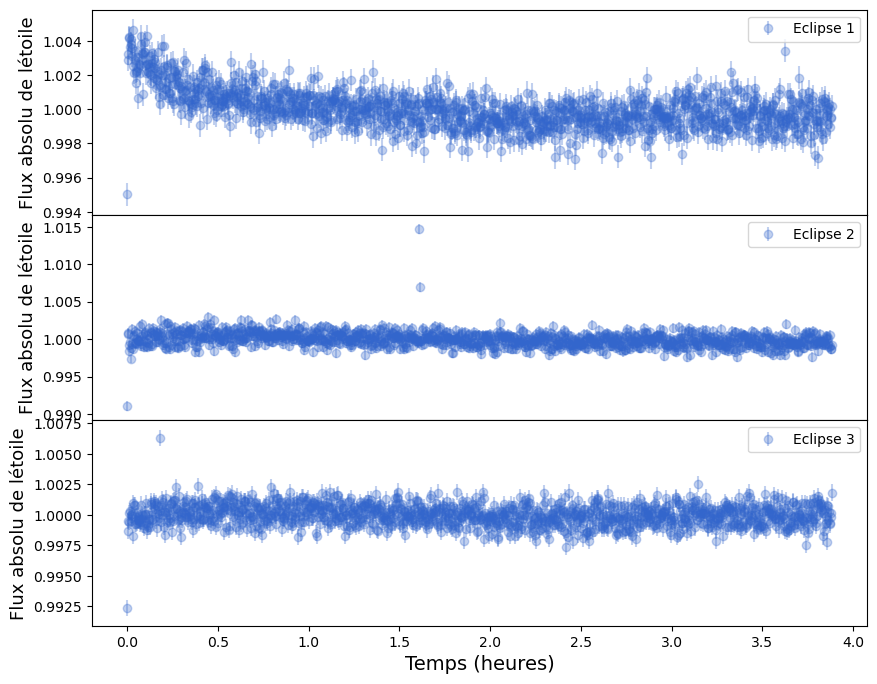

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8))
aperr_norm = {}
aplev_norm = {}
for i, e in enumerate(eclipses):
    aperr_norm[e] = aperr_arr[e]/np.mean(aplev_arr[e])
    aplev_norm[e] = aplev_arr[e]/np.mean(aplev_arr[e])
    ax[i].errorbar((time_arr[e]-time_arr[e][0])*24, aplev_norm[e], yerr=aperr_norm[e], fmt='o', label='Eclipse '+e, alpha=0.3, color='#3366cc')
    ax[i].set_ylabel('Flux absolu de l''étoile', fontsize=13)
    # make labelfont size bigger
    ax[i].legend()
ax[0].tick_params(labelbottom=False)
ax[1].tick_params(labelbottom=False)
ax[2].set_xlabel('Temps (heures)', fontsize=14)
plt.subplots_adjust(hspace=0)
#plt.tight_layout()
plt.show()

1260 1260 1260 3780 3780
0.09827457404753659
2.358589777140878 47.69218977706623


Text(0.5, 0, 'Time (days)')

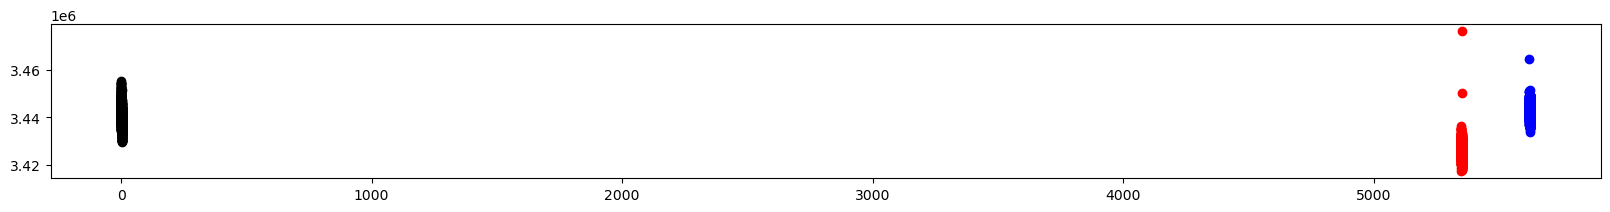

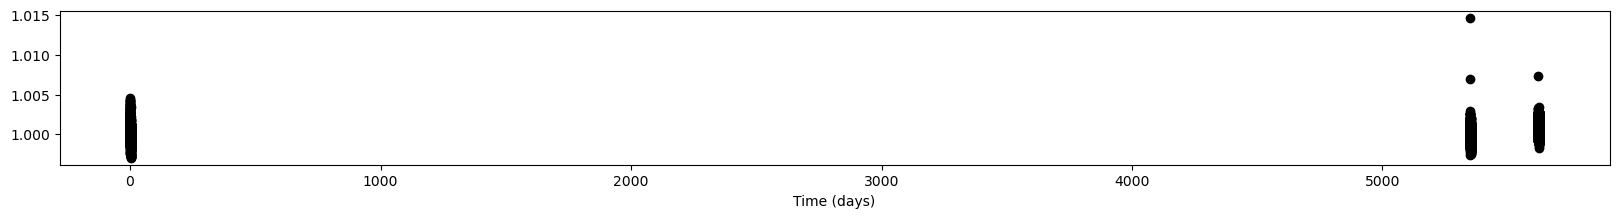

In [22]:
ndiscard = 2
len1 = len(time_arr['1'])-ndiscard
len2 = len(time_arr['2'])-ndiscard
len3 = len(time_arr['3'])-ndiscard
# starting points
# e1 = 0
# e2 = len1
# e3 = len1 + len2
time = np.concatenate((time_arr['1'][ndiscard:], time_arr['2'][ndiscard:], time_arr['3'][ndiscard:]))
aplev = np.concatenate((aplev_arr['1'][ndiscard:]/np.mean(aplev_arr['1'][ndiscard:]), aplev_arr['2'][ndiscard:]/np.mean(aplev_arr['2'][ndiscard:]), aplev_arr['3'][ndiscard:]/np.mean(aplev_arr['1'][ndiscard:])))
aperr = np.concatenate((aperr_norm['1'][ndiscard:], aperr_norm['2'][ndiscard:], aperr_norm['3'][ndiscard:]))
#aplev = aplev / np.mean(aplev)
centroid_x = np.concatenate((centroid_x_arr['1'][ndiscard:], centroid_x_arr['2'][ndiscard:], centroid_x_arr['3'][ndiscard:]))
centroid_y = np.concatenate((centroid_y_arr['1'][ndiscard:], centroid_y_arr['2'][ndiscard:], centroid_y_arr['3'][ndiscard:]))

print(len1, len2, len3, (len1+len2+len3), len(time))

p0_e1 = [0.00344908196627231, 2.1384616526923503, 0.9996595799196581]
p0_e2 = [0.9442588023676416, 0.00023172786914537203, 0.056190963345282764] #len1]
p0_e3 = [0.284437766861067, 0.0003218453369957566, 0.7158164845760568] # len1+len2]

ecl = Time('2023-11-27 21:00', format = 'iso', scale = 'tdb')
ecl = ecl.mjd
print(ecl-time[0])
t_s = (60275.875-time[0])*(24)
ecl = t_s
t0 = (58388.7939-time[0])*(24)
per = 3.777940*24
t0 = t0+(per*500)
print(t_s, t0)
fp = 0.000230
p0_astro = np.array([t_s, fp]) 
time = (time - time[0])*(24)

plt.figure(figsize=(20, 2))
plt.plot(time[0:len1], aplev_arr['1'][ndiscard:], 'ok')
plt.plot(time[len1:(len1+len2)], aplev_arr['2'][ndiscard:], 'or')
plt.plot(time[(len1+len2):], aplev_arr['3'][ndiscard:], 'ob')
plt.figure(figsize=(20, 2))
plt.plot(time, aplev, 'ok')
plt.xlabel('Time (days)')

[5621.57837417 5621.5814529  5621.58453162 ... 5625.44832922 5625.45140794
 5625.45448666] [1.00047317 1.00036443 1.00111927 ... 1.00076869 1.00113168 1.00277481]


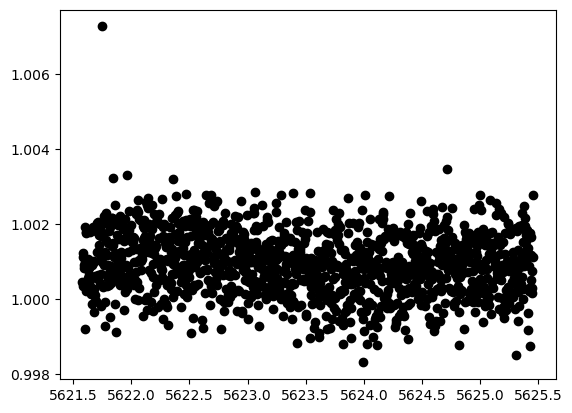

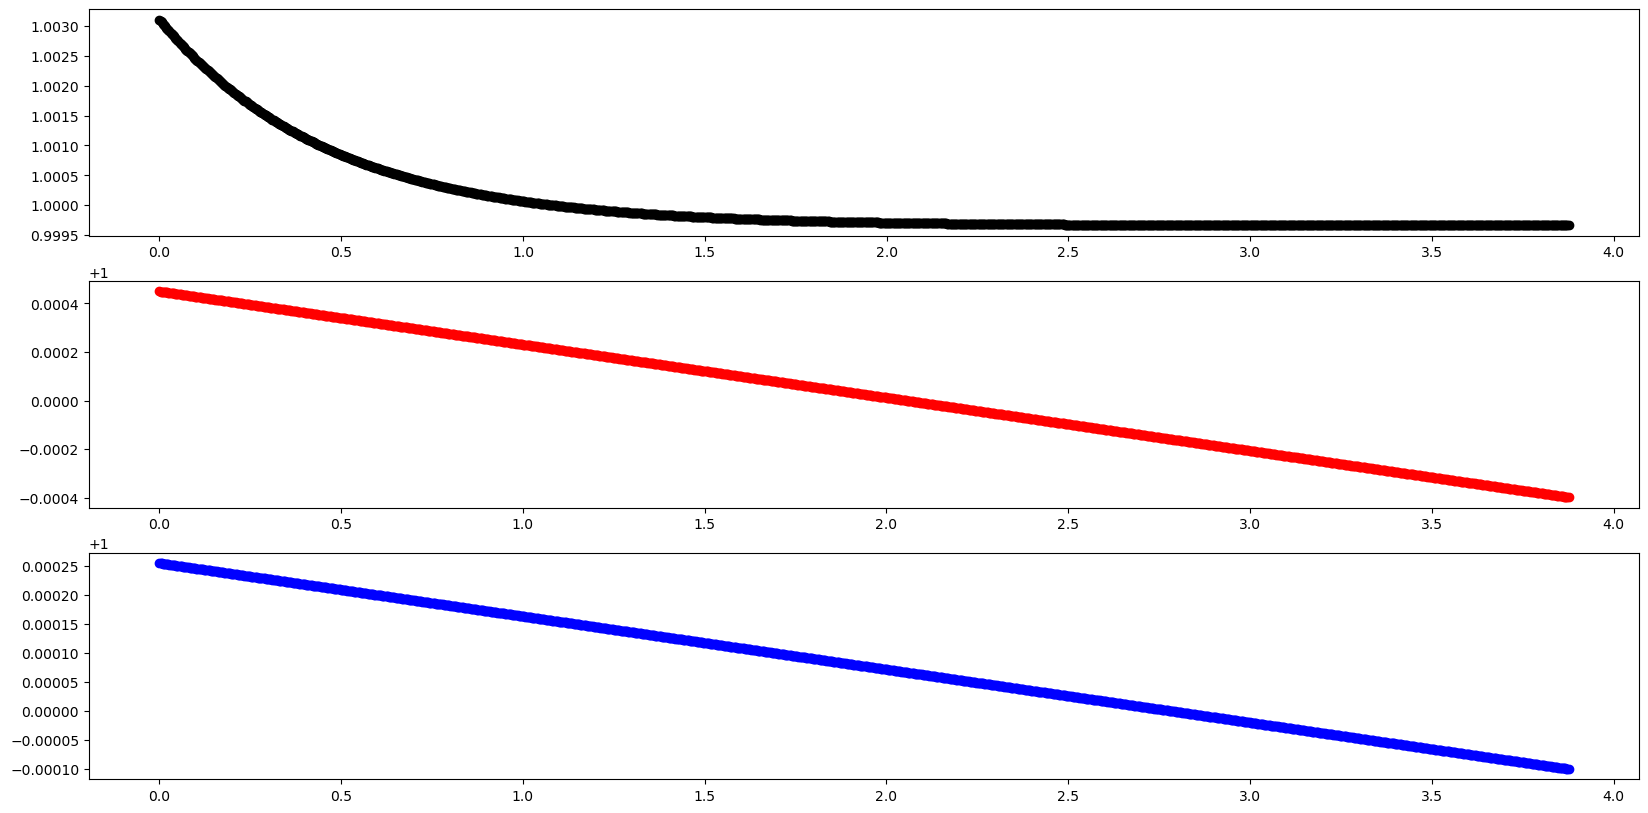

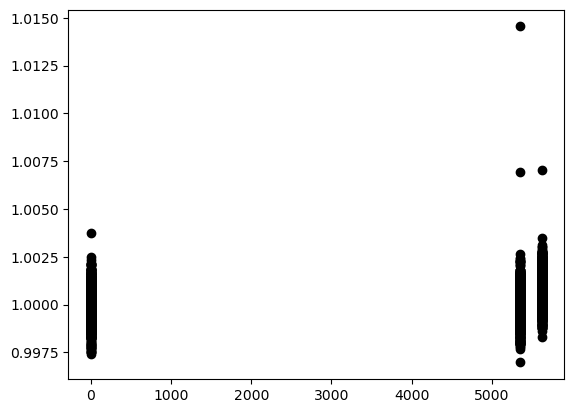

In [12]:
# Split the time array
time_segment_1 = time[:len1]
time_segment_2 = time[len1:len1+len2]
time_segment_3 = time[len1+len2:]
aplev_segment_1 = aplev[:len1]
aplev_segment_2 = aplev[len1:len1+len2]
aplev_segment_3 = aplev[len1+len2:]
print(time_segment_3, aplev_segment_3)
plt.plot(time_segment_3, aplev_segment_3, 'ok')

# Apply functions to each segment
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
result1 = exponential_func(time_segment_1-time_segment_1[0], 0.00344908196627231, 2.1384616526923503, 0.9996595799196581)
ax[0].plot(time_segment_1, result1, 'ok')

result2 = exponential_func(time_segment_2-time_segment_2[0], 0.9442588023676416, 0.00023172786914537203, 0.056190963345282764)
#ax[1].plot(time_segment_2, aplev_segment_2, 'ob')
ax[1].plot(time_segment_2-time_segment_2[0], result2, 'or')

result3 = exponential_func(time_segment_3-time_segment_3[0], 0.284437766861067, 0.0003218453369957566, 0.7158164845760568)
#ax[2].plot(time_segment_3-time_segment_3[0], result3, 'ob')
ax[2].plot(time_segment_3 - time_segment_3[0], result3, 'ob')  # Corrected

#ax[2].plot(time_segment_3, aplev_segment_3, 'ob')

# Combine results back into one array
plt.figure()
final_result = np.concatenate([result1, result2, result3])
plt.plot(time, aplev/final_result, 'ok')


(0.999, 1.001)

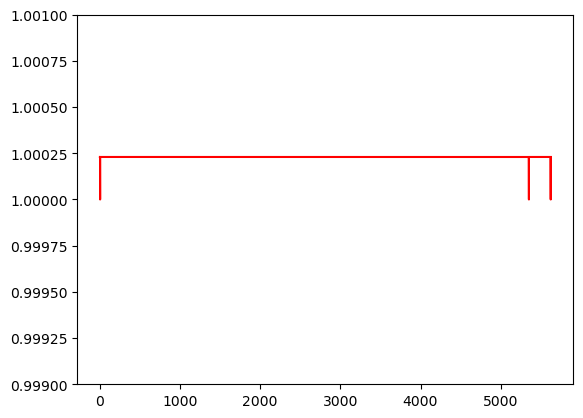

In [13]:
flux = transit_model(time, t_s, fp)

plt.plot(time, flux, '-r')
plt.ylim(0.999, 1.001)
#plt.xlim(-1, 5)
#plt.xlim(5340, 5360)
#plt.xlim(5620, 5630)

In [46]:
p0 = np.concatenate((p0_astro, p0_e1, p0_e2, p0_e3, [0.001]))
nsteps, nwalkers, ndim = 100000, 70, len(p0)

# lower the initial position scatter
pos = p0 + 1e-5 * np.random.randn(nwalkers, ndim)

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(time, aplev, centroid_x, centroid_y)) 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(time, aplev))

pos2, prob, state = sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 100000/100000 [1:04:45<00:00, 25.74it/s]


In [47]:
nBurnInSteps2 = 1000
lnprobchain = sampler.get_log_prob(discard=nBurnInSteps2).swapaxes(0,1)
chain = sampler.get_chain(discard=nBurnInSteps2).swapaxes(0,1)

# Save the chains
savepath = 'Joint_results/try3_'
pathchain = savepath + 'samplerchain_10000.npy'
pathlnlchain = savepath + 'samplerlnlchain_10000.npy'
pathposit = savepath + 'samplerposi_10000.npy'
pathlnpro = savepath + 'samplerlnpr_10000.npy'
np.save(pathchain, chain)
np.save(pathlnlchain, lnprobchain)
np.save(pathposit, pos2)
np.save(pathlnpro, prob)

In [39]:
# load previous results
path = 'Joint_results/try3_'
chain = np.load(path +'samplerchain_10000.npy')
lnprobchain = np.load(path  + 'samplerlnlchain_10000.npy')
pos2 = np.load(path + 'samplerlnlchain_10000.npy')
prob = np.load(path + 'samplerlnlchain_10000.npy')

In [48]:
samples = chain.reshape((-1, ndim))

MCMC_Results = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))))

maxk, maxiter = np.unravel_index((lnprobchain).argmax(), (lnprobchain).shape)
p0_mcmc = chain[maxk, maxiter,:]
for i in range(len(p0_mcmc)):
    MCMC_Results[i] = (p0_mcmc[i], MCMC_Results[i][1], MCMC_Results[i][2])

p0_labels = ['t_s','fp', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9', 'c_10', 'c_11', 'c_12', 'c_13', 'sigF']
p0_labels[ndim-1] ='sigF'

out = "MCMC result:\n\n"
for i in range(len(p0_mcmc)):
    out += '{:>8} = {:>16}  +{:>16}  -{:>16}\n'.format(p0_labels[i],MCMC_Results[i][0], MCMC_Results[i][1], MCMC_Results[i][2])
print(out, flush=True)
p0_centroid = p0_mcmc

MCMC result:

     t_s = 2.2831668837023456  +0.015496318218180871  -0.017248347842887757
      fp = 0.00028772800438750567  +3.278370711251984e-05  -3.265848076788657e-05
     c_1 = 0.0034818836808606264  +0.00014668734083275476  -0.00014046683343482778
     c_2 = 2.084655151974435  +0.17233093363051033  -0.15434977914169412
     c_3 = 0.9993598350864715  +3.787517919351391e-05  -3.956059321719163e-05
     c_4 = 0.7373987872497543  +3.044489277719383  -0.807083871398334
     c_5 = 0.00030489546774143376  +0.0006519096275635915  -0.00015618790795256975
     c_6 = 0.2628320962834447  +0.8070587047189657  -3.0444829710019734
     c_7 = 0.33983778035282197  +4.021759872134847  -0.4282193674328449
     c_8 = 0.00028711806110223243  +0.0011188595310584353  -0.00015623687223323556
     c_9 =  0.6611019557645  +0.42822457361502664  -4.0216831636017005
    sigF = 0.0008552064024674661  +1.033863672581306e-05  -9.702800127790517e-06



(0.998, 1.002)

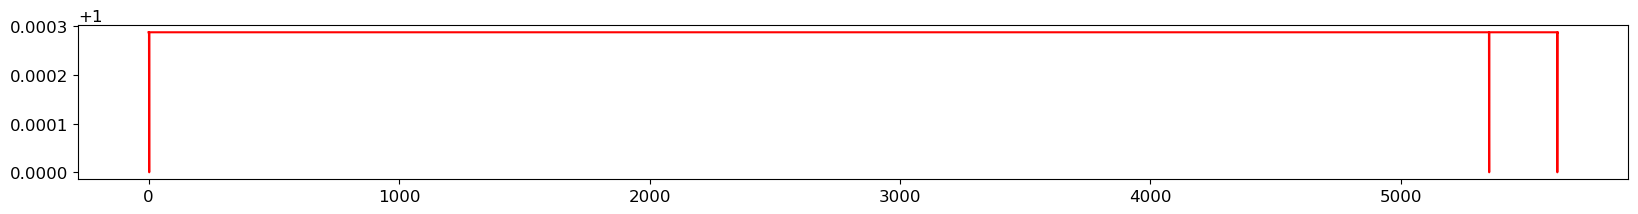

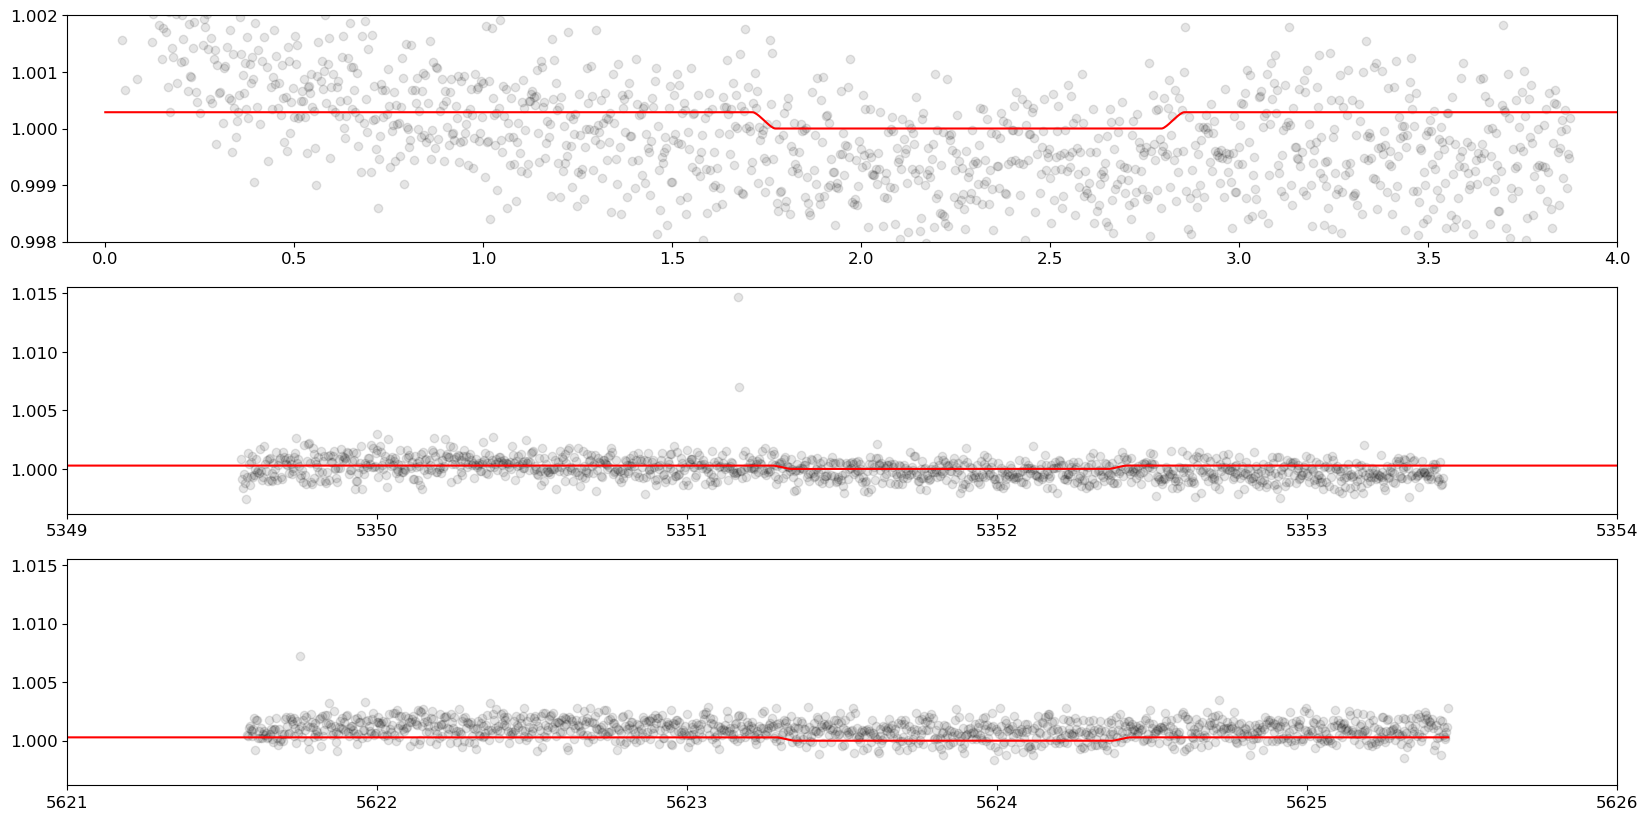

In [49]:
t_s = p0_mcmc[0]
fp = p0_mcmc[1]
flux = transit_model(time, t_s, fp)
plt.figure(figsize=(20, 2))
#plt.plot(time, aplev, 'ok', alpha=0.1)
plt.plot(time, flux, '-r')
#plt.xlim(5200, 5400)

fig, ax = plt.subplots(3, 1, figsize=(20, 10))
ax[0].plot(time, aplev, 'ok', alpha=0.1)
ax[0].plot(time, flux, '-r')
ax[0].set_xlim(-0.1, 4)
ax[0].set_ylim(0.998, 1.002)
ax[1].plot(time, aplev, 'ok', alpha=0.1)
ax[1].plot(time, flux, '-r')
ax[1].set_xlim(5349, 5354)
ax[0].set_ylim(0.998, 1.002)
ax[2].plot(time, aplev, 'ok', alpha=0.1)
ax[2].plot(time, flux, '-r')
ax[2].set_xlim(5621, 5626)
ax[0].set_ylim(0.998, 1.002)

# barres derreur

In [50]:
print(p0_mcmc[0], ecl)
print((ecl-p0_mcmc[0])*60)

2.2831668837023456 2.358589777140878
4.525373606311955


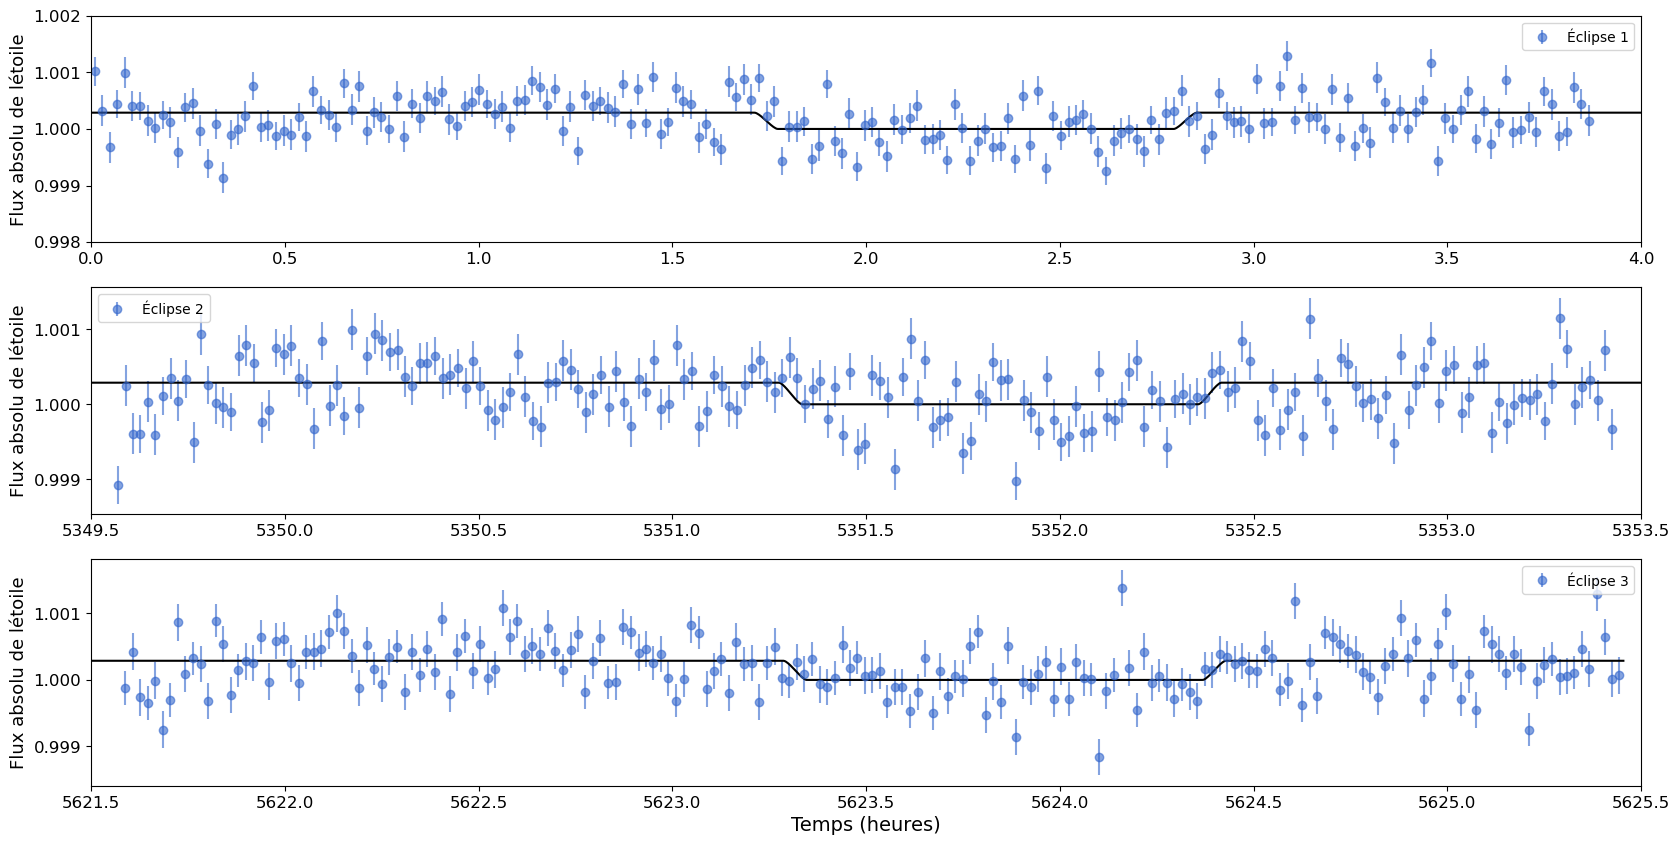

In [51]:
nbin = 200
time_segment_1 = time[:len1]
time_segment_2 = time[len1:len1+len2]
time_segment_3 = time[len1+len2:]
aplev_segment_1 = aplev[:len1]
aplev_segment_2 = aplev[len1:len1+len2]
aplev_segment_3 = aplev[len1+len2:]
aperr_segment_1 = aperr[:len1]
aperr_segment_2 = aperr[len1:len1+len2]
aperr_segment_3 = aperr[len1+len2:]

bins_time1, binErr_t = binValues(time_segment_1, time_segment_1, nbin)
bins_aplev1, binErr_aplev1 = binFluxError(aplev_segment_1, aperr_segment_1, time_segment_1, nbin)
bins_time2, binErr_t = binValues(time_segment_2, time_segment_2, nbin)
bins_aplev2, binErr_aplev2 = binFluxError(aplev_segment_2, aperr_segment_2, time_segment_2, nbin)
bins_time3, binErr_t = binValues(time_segment_3, time_segment_3, nbin)
bins_aplev3, binErr_aplev3 = binFluxError(aplev_segment_3, aperr_segment_3, time_segment_3, nbin)

fig, ax = plt.subplots(3, 1, figsize=(20, 10))
ax[0].errorbar(bins_time1, bins_aplev1/exponential_func(bins_time1, 0.0035195976487543655, 2.0649261737528786, 0.999366464321820), yerr= binErr_aplev1, linestyle='', marker='o', color='#3366cc', alpha=0.6, label='Éclipse 1')
ax[0].plot(time, flux, '-k')
ax[0].set_xlim(0, 4)
#ax[0].set_ylim(0.998, 1.002)
ax[1].errorbar(bins_time2, bins_aplev2/exponential_func(bins_time2-bins_time2[0], 0.7931758239432235, 0.00028176255386267904, 0.20706873927518615), yerr= binErr_aplev2, linestyle='', marker='o', color='#3366cc', alpha=0.6,  label='Éclipse 2')
ax[1].plot(time, flux, '-k')
ax[1].set_xlim(5349.5, 5353.5)
ax[0].set_ylim(0.998, 1.002)
ax[2].errorbar(bins_time3, bins_aplev3/exponential_func(bins_time3-bins_time3[0], 0.0637291774041382, 0.0015556758405141193, 0.9372273625802439), yerr= binErr_aplev3, linestyle='', marker='o', color='#3366cc', alpha=0.6, label='Éclipse 3')
ax[2].plot(time, flux, '-k')
ax[2].set_xlim(5621.5, 5625.5)
ax[0].set_ylim(0.998, 1.002)
ax[0].set_ylabel('Flux absolu de l''étoile', fontsize=13)
ax[1].set_ylabel('Flux absolu de l''étoile', fontsize=13)
ax[2].set_ylabel('Flux absolu de l''étoile', fontsize=13)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[2].set_xlabel('Temps (heures)', fontsize=14)
plt.savefig('Joint_results/try3.png')   
plt.show()

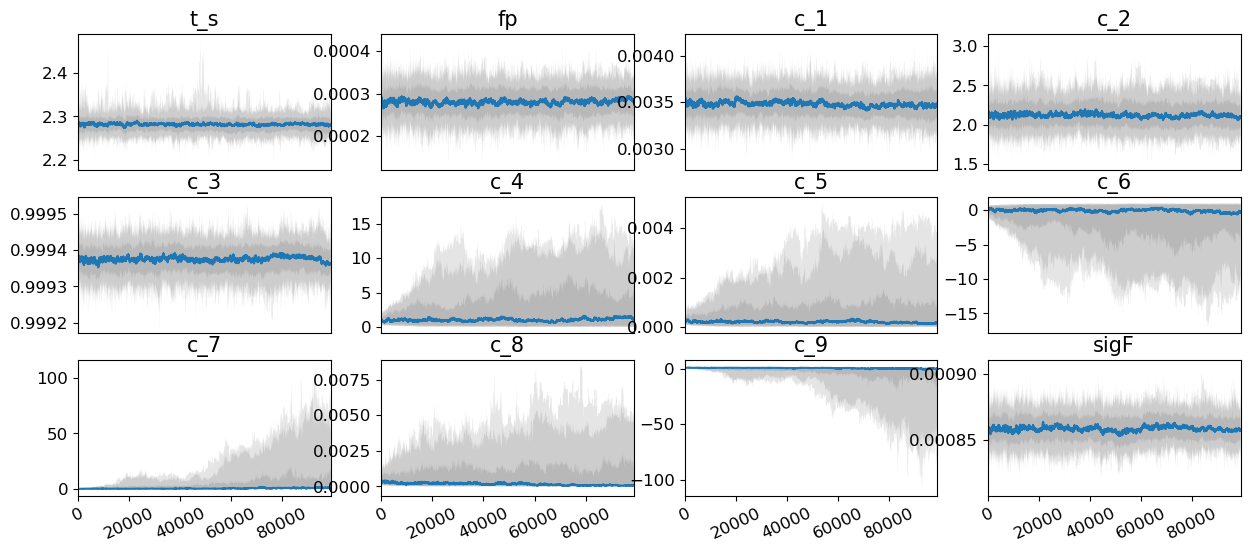

In [52]:
walk_style(chain, p0_labels, interv=10, fname='Joint_results/try3_walkers.png', showPlot=True, fontsize=15)

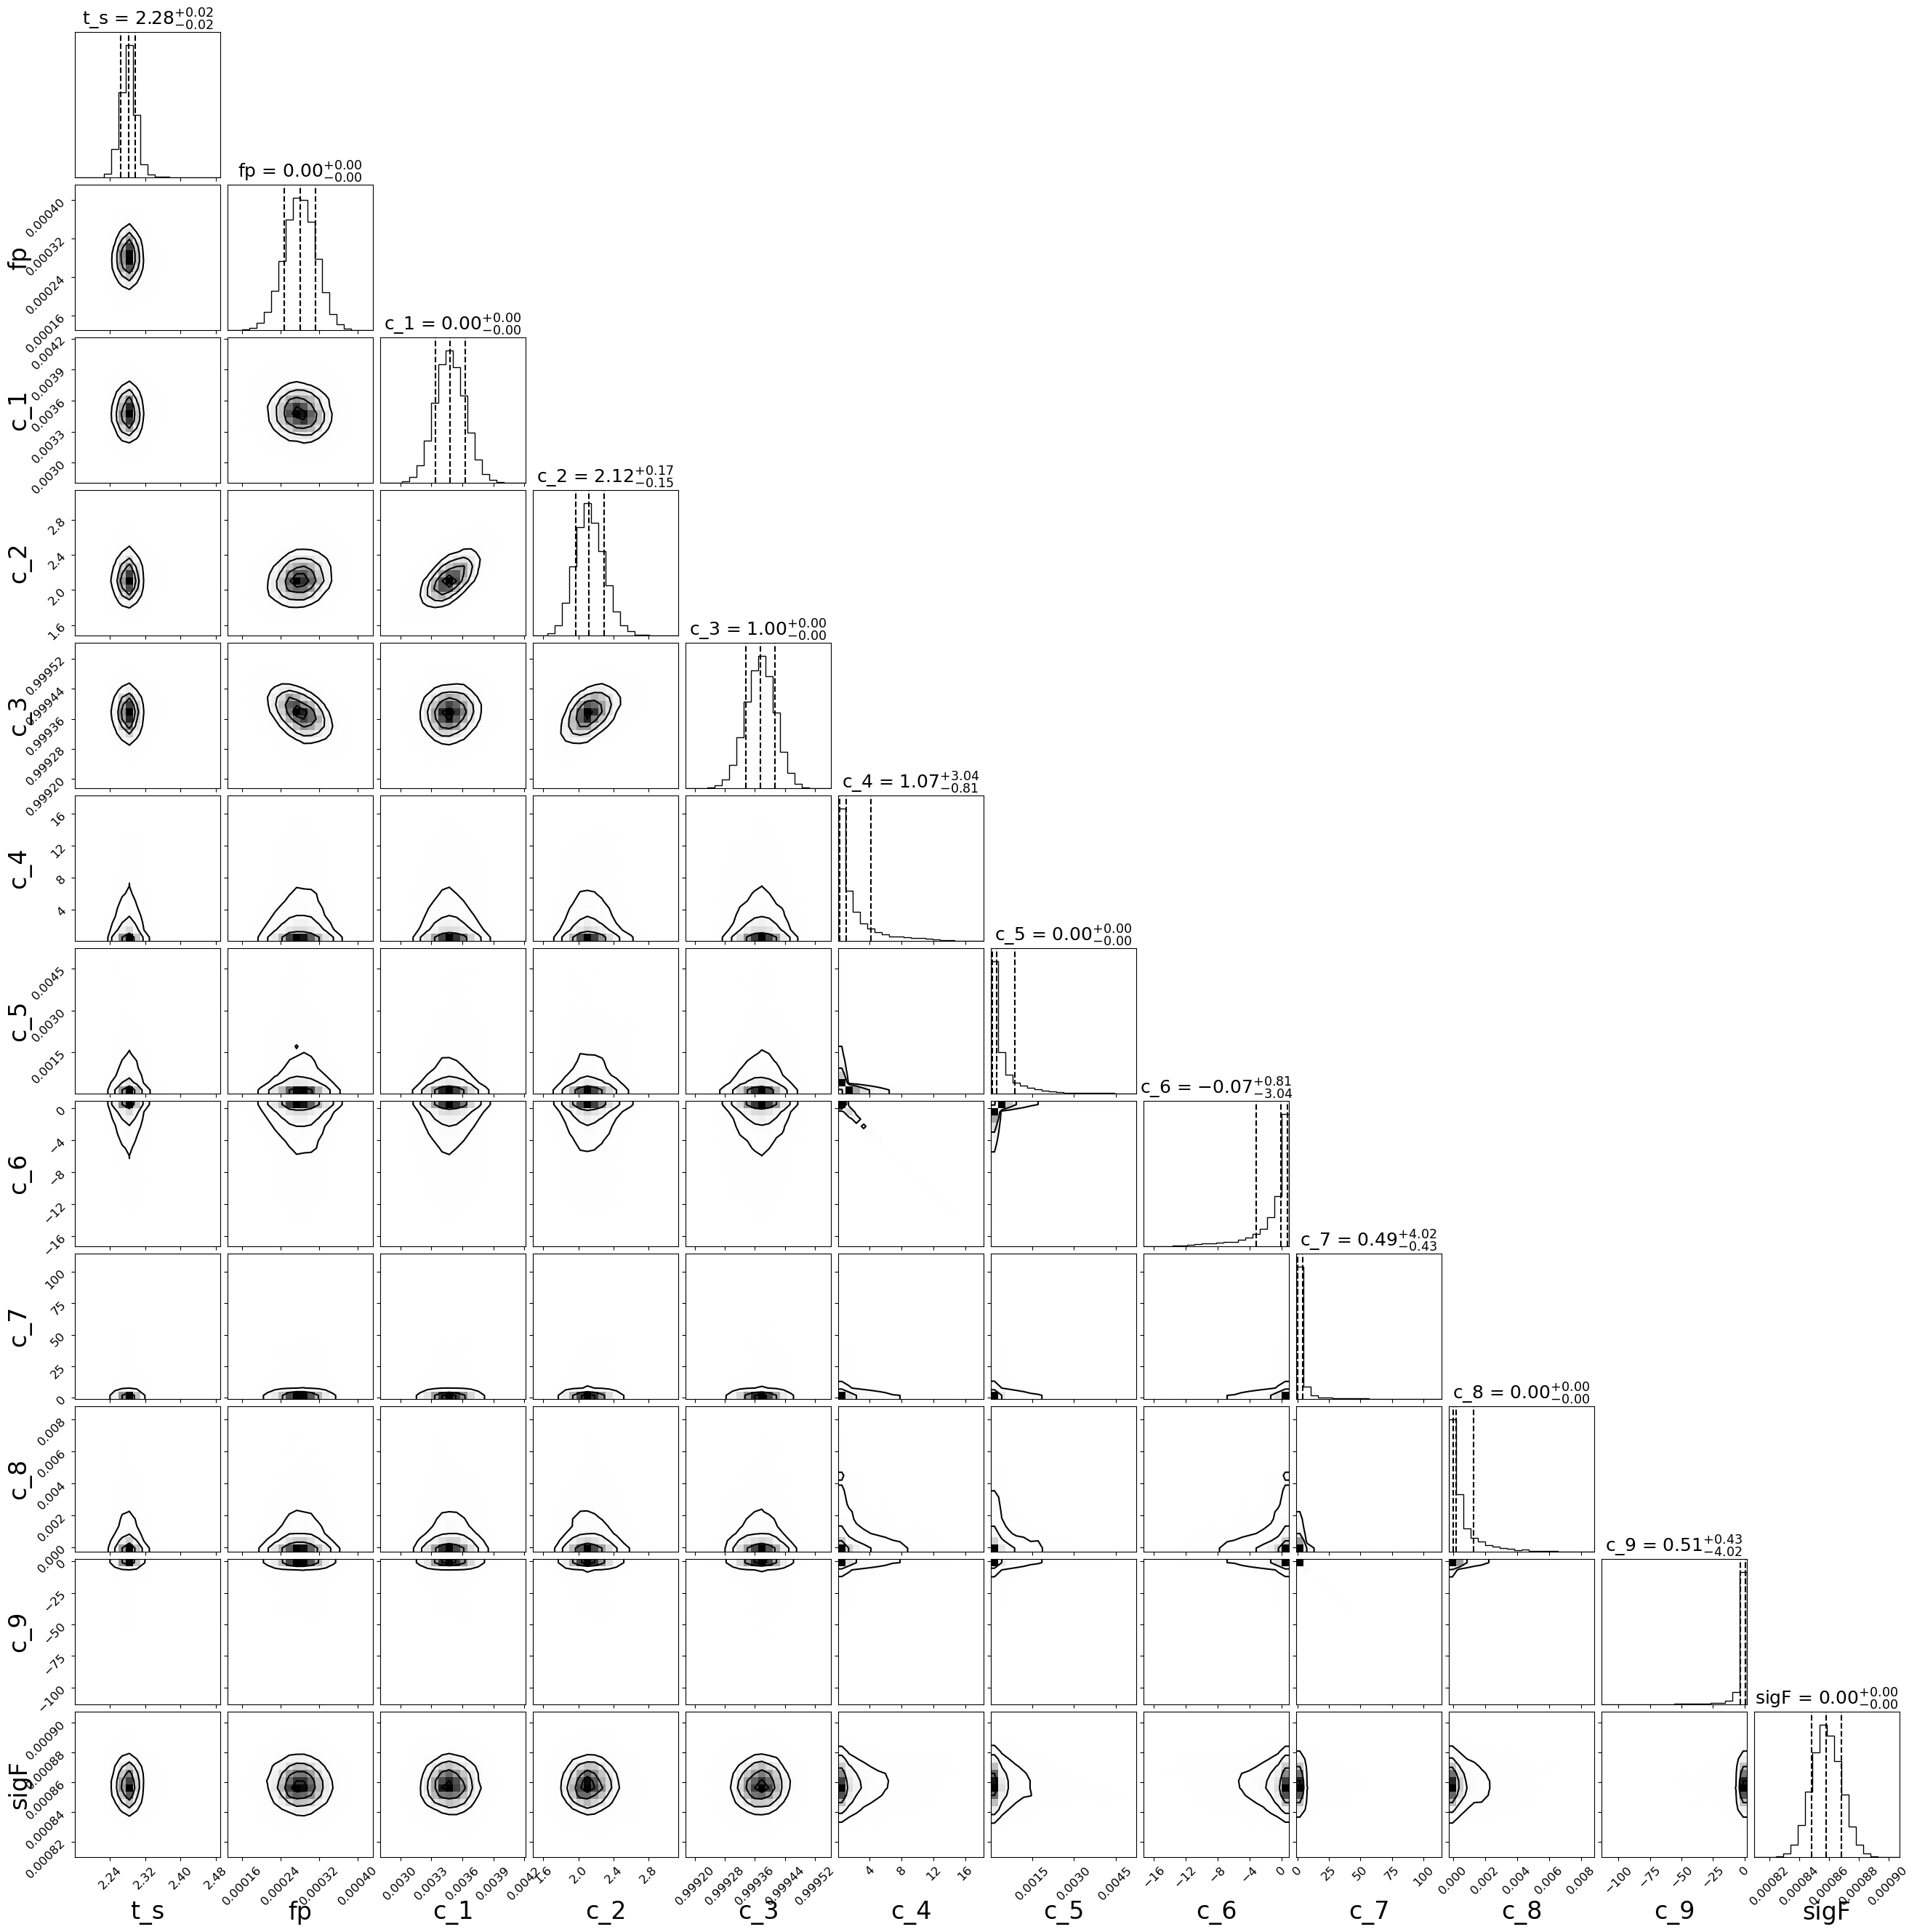

In [53]:
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

samples = chain.reshape((-1, ndim))
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], labels = p0_labels, show_titles=True,
                        plot_datapoints=False, label_kwargs={"fontsize": 24}, title_kwargs={"fontsize": 18}, quiet=False)

fig.savefig('Joint_results/try3_corners.png')
#plt.close()

In [10]:
# All the astrophysical and noise models are defined here to be used in the analysis.
# There are different options for the noise model, and they can be combined with the a second-order polynomial model for the centroids

def transit_model(time, t_s, fp):
    # this model is based on the batman package
    # fits specifically for secondary eclipses
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = t0                        #time of inferior conjunction
    params.per = 3.777940*24              #orbital period in hours
    params.rp = 0.0539                    #planet radius (in units of stellar radii) # check that this is ratio of radii -> 0.0539 is charles value
    params.a = 26.57                      #semi-major axis (in units of stellar radii)
    params.inc = 89.8                     #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [0.16, 0.22]               #limb darkening coefficients, values from cadieux 2024b
    params.fp = fp                        #planet to star flux ratio
    params.t_secondary = t_s

    m = batman.TransitModel(params, time, transittype="secondary")
    flux = m.light_curve(params)
    return flux

def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

def double_exponential(time, c1, c2, c3, c4):
    return c1 * np.exp(-c2 * time) + c3 * np.exp(-c4 * time)

def detec_model_poly(xdata, ydata, c1, c2, c3, c4, c5, c6):
    x, y = xdata, ydata
    pos = np.vstack((np.ones_like(x),
                     x   ,      y,
                     x**2, x   *y,      y**2))
    detec = np.array([c1, c2, c3, c4, c5, c6])
    return np.dot(detec[np.newaxis,:], pos).reshape(-1)

def signal(time, theta):
    t_s = theta[0]
    fp = theta[1]
    astro = transit_model(time, t_s, fp)

    time_segment_1 = time[:len1]
    time_segment_2 = time[len1:len1+len2]
    time_segment_3 = time[len1+len2:]
    result1 = exponential_func(time_segment_1-time_segment_1[0], *theta[2:5])
    result2 = exponential_func(time_segment_2-time_segment_2[0], *theta[5:8])
    result3 = exponential_func(time_segment_3-time_segment_3[0], *theta[8:11])
    detec = np.concatenate([result1, result2, result3])

    return astro*detec

# bin the data
def binValues(values, binAxisValues, nbin, assumeWhiteNoise=True):
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))
    if assumeWhiteNoise:
        binnedErr /= np.sqrt(len(values)/nbin)
    return binned, binnedErr

# retrieve proper errorbars on aplev
def binFluxError(values, error, binAxisValues, nbin, assumeWhiteNoise=True):
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binCounts = np.array([np.sum(digitized == i) for i in range(1, nbin)])

    binnedErr = np.array([np.mean(error[digitized == i]) for i in range(1, nbin)])/np.sqrt(binCounts)

    return binned, binnedErr

# plotting functions
def walk_style(chain, labels, interv=10, fname=None, showPlot=False, fontsize=15):
    nwalk = chain.shape[0]
    ndim = chain.shape[-1]

    # get first index
    beg   = 0
    end   = len(chain[0,:,0])
    step  = np.arange(beg,end)
    step  = step[::interv]

    # number of columns and rows of subplots
    ncols = 4
    nrows = int(np.ceil(ndim/ncols))
    sizey = 2*nrows

    # plotting
    plt.figure(figsize = (15, 2*nrows))
    for ind in range(ndim):
        plt.subplot(nrows, ncols, ind+1)
        sig1 = (0.6827)/2.*100
        sig2 = (0.9545)/2.*100
        sig3 = (0.9973)/2.*100
        percentiles = [50-sig3, 50-sig2, 50-sig1, 50, 50+sig1, 50+sig2, 50+sig3]
        neg3sig, neg2sig, neg1sig, mu_param, pos1sig, pos2sig, pos3sig = np.percentile(chain[:,:,ind][:,beg:end:interv],
                                                                                       percentiles, axis=0)
        plt.plot(step, mu_param)
        plt.fill_between(step, pos3sig, neg3sig, facecolor='k', alpha = 0.1)
        plt.fill_between(step, pos2sig, neg2sig, facecolor='k', alpha = 0.1)
        plt.fill_between(step, pos1sig, neg1sig, facecolor='k', alpha = 0.1)
        plt.title(labels[ind], fontsize=fontsize)
        plt.xlim(np.min(step), np.max(step))
        if ind < (ndim - ncols):
            plt.xticks([])
        else:
            plt.xticks(rotation=25)

        y_formatter = ScalarFormatter(useOffset=False)
        plt.gca().yaxis.set_major_formatter(y_formatter)
        plt.gca().xaxis.set_tick_params(labelsize=fontsize*0.8)
        plt.gca().yaxis.set_tick_params(labelsize=fontsize*0.8)

    if fname != None:
        plt.savefig(fname, bbox_inches='tight')

    if showPlot:
        plt.show()

    #plt.close()
    return

In [11]:
# MCMC functions
def log_likelihood(theta, time, flux):
    model = signal(time, theta)
    sigF = theta[-1]
    sigma2 = sigF**2
    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    prior = 0.
    t_s = theta[0]
    fp = theta[1]
    sigF = theta[-1]
    
    if (0 < fp < 1 and sigF > 0. ): # (eclipse-(e_dur_days/2)) < t_s < (eclipse+(e_dur_days/2)) and 
        return 0.0 + prior
    return np.inf

def log_prob(theta, time, flux):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, time, flux)